In [50]:
import math
import numpy as np
from statistics import mean
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [51]:
df=sc.textFile('s3://geocluster/Data/sample_geo2.csv')


In [52]:
df=df.map(lambda x:x.split(',')).cache()

In [53]:
latlongdf=df.map(lambda x:(int(x[0]),float(x[1]),float(x[2])))

In [54]:
def Great_circle(lat1,lon1,lat2,lon2):
    radius = 6371;

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

def Euclidean(lat1,lat2, lon1,lon2):
    d_length = 110.25
    x= lat2 - lat1
    y= (lon2 - lon1)*math.cos(math.radians(lat1))
    return d_length*math.sqrt(x*x + y*y)

def Centroid(old,new):
    return [math.sqrt((old[i][0]-new[i][0])**2+(old[i][1]-new[i][1])**2) for i in range(0,k)]

def Equality(old,new):
    for i in range(0,k):
        if(old[i][0]!=new[i][0] or old[i][1]!=new[i][1]):
            return False;
    return True;




In [71]:
k=2
distance="Great_circle"
iterations=50
convergedistance=0.01
ic=latlongdf.map(lambda x:(x[1],x[2])).takeSample(False, k);
output=[];
output.extend(ic);

for i in range(0,iterations):
    if(distance=="euclidean"):
        rddce=latlongdf.map(lambda x:(x[0],x[1],x[2],[Euclidean(x[1],x[2],ic[z][0],ic[z][1]) for z in range(0,k)],np.argmin([Euclidean(x[1],x[2],ic[j][0],ic[j][1]) for j in range(k)])))
        rdddist=latlongdf.map(lambda x:(np.argmin([Euclidean(x[1],x[2],ic[j][0],ic[j][1]) for j in range(0,k)]),(x[1],x[2])))
    elif(distance=="Great_circle"):
        rddce=latlongdf.map(lambda x:(x[0],x[1],x[2],[Great_circle(x[1],x[2],ic[z][0],ic[z][1]) for z in range(0,k)],np.argmin([Great_circle(x[1],x[2],ic[j][0],ic[j][1]) for j in range(k)])))
        rdddist=latlongdf.map(lambda x:(np.argmin([Great_circle(x[1],x[2],ic[j][0],ic[j][1]) for j in range(0,k)]),(x[1],x[2])))
    rddist=rdddist.groupByKey().map(lambda x:(mean([k[0] for k in x[1]]),mean([k[1] for k in x[1]]))) 
    old=ic;
    new=rddist.collect();
    if(len(new)<k):
        diff=(k-len(new));
        exclus=latlongdf.map(lambda x:(x[1],x[2])).takeSample(False,diff);
        new.extend(exclus)
    dist=sum(Centroid(old,new))
    if(dist<=convergedistance or Equality(old,new)):
        print(dist)
        break;
    else:
        ic=new;
        output.extend(ic)
        print(ic)
        
        

[(37.203221720512325, -109.92386591561933), (37.88234391145658, -80.70542944838658)]
[(36.91593317654486, -111.80881207092257), (37.962380885426036, -81.27993798242159)]
[(37.31027464190267, -113.46236757769047), (37.793876113238646, -81.77577839315155)]
[(37.75853990400801, -115.35730827559608), (37.64715854132867, -82.28691539262108)]
[(38.053095290230154, -116.31963802403945), (37.568870818447905, -82.52751948886366)]
[(38.072500556153116, -116.42534475898866), (37.5644442046766, -82.55497328181055)]
[(38.07161548087943, -116.43342043085106), (37.56474719519924, -82.5571108152909)]
0.0


In [72]:
pd.DataFrame(output).to_csv('s3://geocluster/geocenG2.csv')

In [73]:
df2=rdddist.map(lambda x:(float(x[0]),x[1][0],x[1][1])).toDF().toPandas()
df2.columns=['index','latitude','longitude']

df3=pd.DataFrame(ic,columns=['latitude','longitude'])

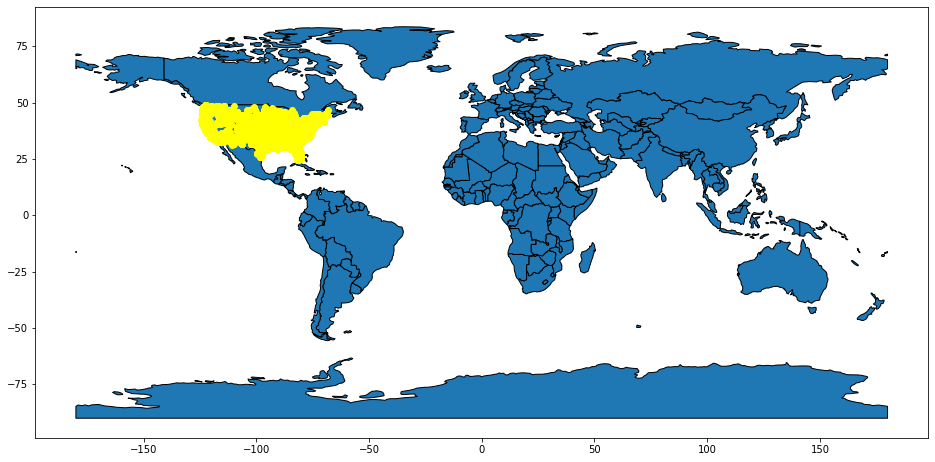

In [74]:
gdf = geopandas.GeoDataFrame(
    df2, geometry=geopandas.points_from_xy(df2.longitude, df2.latitude,df2.index))


world_map = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# restricted to South America.
ax = world_map.plot(
    edgecolor='black',figsize=(16,16))

# PLOTTING
gdf.plot(ax=ax,color='yellow')

plt.show()

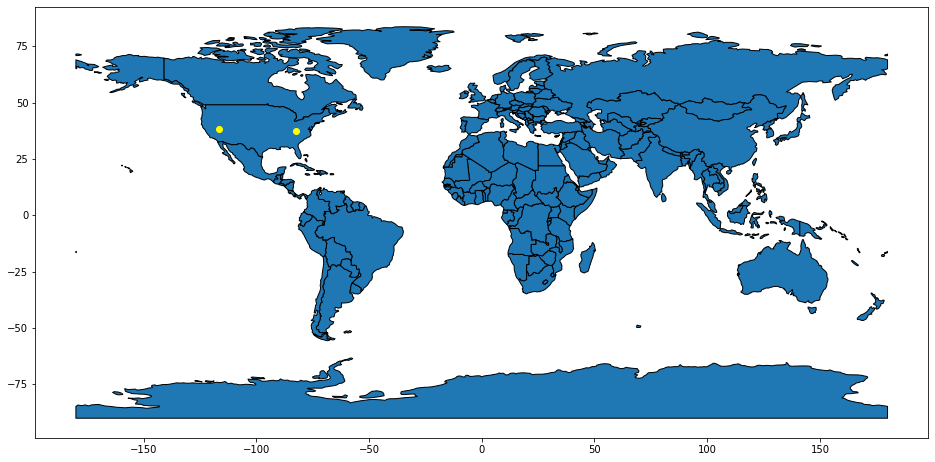

In [76]:
gdf = geopandas.GeoDataFrame(
    df3, geometry=geopandas.points_from_xy(df3.longitude, df3.latitude))


world_map = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#restricted to South America.
ax = world_map.plot(
    edgecolor='black',figsize=(16,16))

# PLOTTING
gdf.plot(ax=ax,color='yellow')

plt.show()